In [1]:
#LSTM
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from sklearn.feature_extraction.text import TfidfVectorizer

#Model building
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

2024-07-25 22:31:21.215210: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 22:31:21.216930: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 22:31:21.254964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 22:31:21.255534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 22:31:22.319745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
# Creating a function to display model results
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    t1.plot()


In [3]:
df = pd.read_csv('/media/yatipa_drive/sep_ana/reduced_dataset_0-end.csv',index_col=0)
product_count = df.groupby('product_name').size().reset_index(name='count').sort_values(by='count', ascending=False)


In [4]:
# ref: https://www.kaggle.com/code/hajaribrahiem/nlp-sentiment-analysis-sephora-reviews
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#removing the stopwords
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
stop=set(stopwords.words('english'))
#Tokenization of text
tokenizer=ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [5]:
# Load the reduced dataset
df = pd.read_csv('reduced_dataset.csv') 
# Shuffling means the data is presented to the model during training in a random order, which prevents it from memorizing the specific sequence and encourages it to learn the general patterns in the data
df = shuffle(df) 
# Preprocess the data
df['review_text'].fillna('', inplace=True)

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-English characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['cleaned_review_text'] = df['review_text'].apply(clean_text)
df['cleaned_review_text']=df['cleaned_review_text'].apply(simple_stemmer) ##########
df['cleaned_review_text']=df['cleaned_review_text'].apply(remove_stopwords) ########## remove stop words in English are “the”, “a”, “an”, “so”, “what”.
# Function to detect language and filter out non-English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Filter out non-English reviews
df = df[df['cleaned_review_text'].apply(is_english)]

# Encode the labels
label_encoder = LabelEncoder()
# 2 1 0 where bad --> good
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Tokenize the cleaned text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review_text'])

# Pad the sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')



In [6]:
X = padded_sequences # df['cleaned_review_text'] #
y = df['sentiment']

# vec = TfidfVectorizer()
# X = vec.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

--------------------------------------Logistic Regression----------------------------------------------


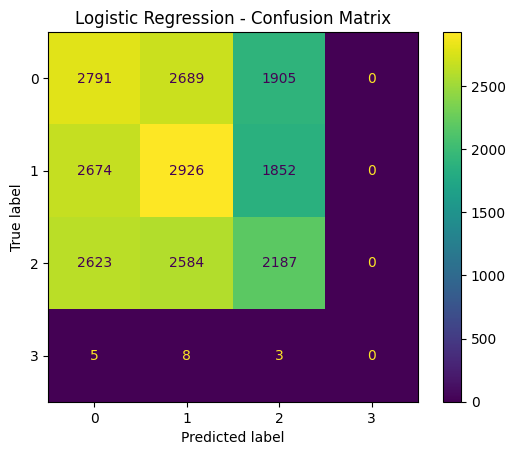

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.34      0.38      0.36      7385
           1       0.36      0.39      0.37      7452
           2       0.37      0.30      0.33      7394
           3       0.00      0.00      0.00        16

    accuracy                           0.36     22247
   macro avg       0.27      0.27      0.27     22247
weighted avg       0.36      0.36      0.35     22247



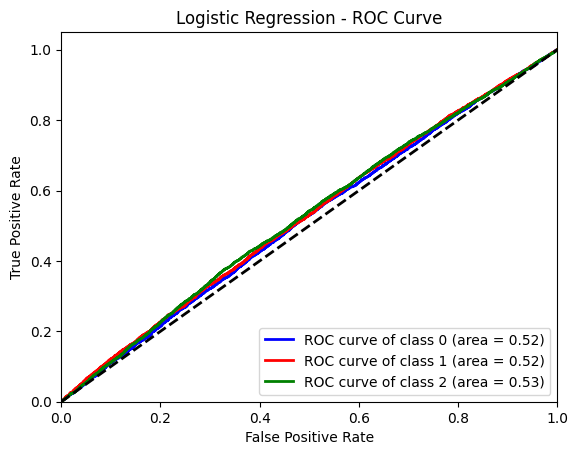

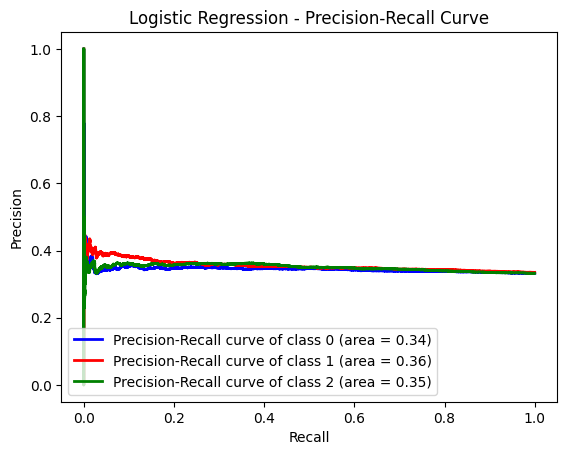

--------------------------------------Random Forest----------------------------------------------


KeyboardInterrupt: 

In [7]:
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    print(f'{name} - Classification Report')
    print(classification_report(y_test, y_pred))

def plot_roc_pr_curves(y_test_bin, y_pred_prob, n_classes, classifier_name):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    precision, recall, average_precision = dict(), dict(), dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    
    colors = cycle(['blue', 'red', 'green'])
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Precision-Recall curve of class {i} (area = {average_precision[i]:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

def run_classifier(classifier, name, param_grid):
    model = classifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)
    
    evaluation_parametrics(name, y_test, y_pred)
    plot_roc_pr_curves(y_test_bin, y_pred_prob, n_classes, name)

# Prepare data
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Define classifiers and parameter grids
classifiers = [
    (LogisticRegression, "Logistic Regression", {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    }),
    (RandomForestClassifier, "Random Forest", {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (MultinomialNB, "Naive Bayes", {
        'alpha': [0.1, 0.5, 1.0]
    })
]

# Run classifiers
for clf, name, param_grid in classifiers:
    print(f'--------------------------------------{name}----------------------------------------------')
    run_classifier(clf, name, param_grid)
# def run_classifier(classifier, name):
#     model = classifier()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_pred_prob = model.predict_proba(X_test)
    
#     evaluation_parametrics(name, y_test, y_pred)
#     plot_roc_pr_curves(y_test_bin, y_pred_prob, n_classes, name)

# # Prepare data
# y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
# n_classes = y_test_bin.shape[1]

# # Define classifiers
# classifiers = [
#     (LogisticRegression, "Logistic Regression"),
#     (RandomForestClassifier, "Random Forest"),
#     (MultinomialNB, "Naive Bayes")
# ]

# # Run classifiers
# for clf, name in classifiers:
#     print(f'--------------------------------------{name}----------------------------------------------')
#     run_classifier(clf, name) 